# DATA LOAD

In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/FootballML

/content/gdrive/MyDrive/FootballML


# DATA PREPROCESING

In [3]:
import datetime
import pandas as pd
from tqdm.auto import tqdm

games = pd.read_csv("games.csv", usecols=["gameID","homeTeamID","awayTeamID", "leagueID", "season"])
teamstats = pd.read_csv("teamstats.csv").drop(columns=["season", "location"])
teamstats["date"] = pd.to_datetime(teamstats["date"])

In [5]:
display(games)

,gameID,leagueID,season,homeTeamID,awayTeamID
0,81,1,2015,89,82
1,82,1,2015,73,71
2,83,1,2015,72,90
3,84,1,2015,75,77
4,85,1,2015,79,78
...,...,...,...,...,...
12675,16131,5,2020,168,166
12676,16132,5,2020,177,176
12677,16133,5,2020,163,235
12678,16134,5,2020,175,181


In [86]:
def create_results(str):
    if str == "W":
      return pd.Series([2, 3])
    if str == "D":
      return pd.Series([1, 1])
    return pd.Series([0, 0])

results = teamstats.apply(lambda row: create_results(row["result"]), axis=1)

teamstats[["result", "points"]] = results

teamstats["total_points"] = teamstats.groupby("teamID")["points"].cumsum()

In [87]:
stats_val = []
for index, row in tqdm(teamstats.iterrows()):
    gameID = row["gameID"]
    team = row["teamID"]
    date = row["date"]
    result = row["result"]
    pastGames = teamstats[(teamstats["teamID"] == team) & (teamstats["date"] < date)].sort_values(by="date", ascending = False)
    last5 = pastGames.head(5)

    goals = pastGames["goals"].mean()
    goals_l5 = last5["goals"].mean()

    xGoals = pastGames["xGoals"].mean()
    xGoals_l5 = last5["xGoals"].mean()

    shots = pastGames["shots"].mean()
    shots_l5 = last5["shots"].mean()

    shotsOnTarget = pastGames["shotsOnTarget"].mean()
    shotsOnTarget_l5 = last5["shotsOnTarget"].mean()

    deep = pastGames["deep"].mean()
    deep_l5 = last5["deep"].mean()

    ppda = pastGames["ppda"].mean()
    ppda_l5 = last5["ppda"].mean()
    
    fouls = pastGames["fouls"].mean()
    fouls_l5 = last5["fouls"].mean()
    
    corners = pastGames["corners"].mean()
    corners_l5 = last5["corners"].mean()
    
    yellowCards = pastGames["yellowCards"].mean()
    yellowCards_l5 = last5["yellowCards"].mean()
    
    redCards = pastGames["redCards"].mean()
    redCards_l5 = last5["redCards"].mean()
    
    points = pastGames["points"].mean()
    points_l5 = last5["points"].mean()

    if len(last5) > 0:
        total_points = pastGames["total_points"].values[0] - pastGames["total_points"].values[-1]
        total_points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1]
    else:
        total_points = 0
        total_points_l5 = 0


    stats_val.append([gameID,team, date,goals, goals_l5, xGoals, xGoals_l5, shots, shots_l5, shotsOnTarget, shotsOnTarget_l5,
     deep, deep_l5, ppda, ppda_l5, fouls, fouls_l5, corners, corners_l5, yellowCards, yellowCards_l5, 
     redCards, redCards_l5, points, points_l5, total_points, total_points_l5, result])


stats_col = ["gameID", "teamID", "date","goals", "goals_l5", "xGoals", "xGoals_l5", "shots", "shots_l5", "shotsOnTarget", "shotsOnTarget_l5",
     "deep", "deep_l5", "ppda", "ppda_l5", "fouls", "fouls_l5", "corners", "corners_l5", "yellowCards", "yellowCards_l5", 
     "redCards", "redCards_l5", "points", "points_l5", "total_points", "total_points_l5", "result"]


teamstats_with_l5 = pd.DataFrame(stats_val, columns=stats_col)
teamstats_with_l5 = teamstats_with_l5.fillna(0)
# teamstats_with_l5.to_csv(path_or_buf="teamstatsv2.csv", index=False)



0it [00:00, ?it/s]

In [119]:
def make_features(gameID,team1ID, team2ID):
    team1_stats = teamstats_with_l5[(teamstats_with_l5["gameID"] == gameID) & (teamstats_with_l5["teamID"] == team1ID)].drop(columns=["teamID", "gameID", "date"])
    result = team1_stats["result"].values[0]
    team1_stats = team1_stats.drop(columns="result").values[0]
    team2_stats = teamstats_with_l5[(teamstats_with_l5["gameID"] == gameID) & (teamstats_with_l5["teamID"] == team2ID)].drop(columns=["teamID", "gameID","date", "result"]).values[0]


    sub = [e1 - e2 for (e1, e2) in zip(team1_stats, team2_stats)]
    temp = [gameID, team1ID, team2ID, result]
    return temp + sub


matches_val = []

# print(games)

for index, row in tqdm(games.iterrows()):
    matches_val.append([row["leagueID"], row["season"]] + make_features(row["gameID"], row["homeTeamID"],row["awayTeamID"]))



matches_col = ["leagueID", "season", "gameID","homeTeamID", "awayTeamID","result","goals", "goals_l5", "xGoals", "xGoals_l5", "shots", "shots_l5", "shotsOnTarget", "shotsOnTarget_l5",
     "deep", "deep_l5", "ppda", "ppda_l5", "fouls", "fouls_l5", "corners", "corners_l5", "yellowCards", "yellowCards_l5", 
     "redCards", "redCards_l5", "points", "points_l5", "total_points", "total_points_l5"]


matches = pd.DataFrame(matches_val, columns=matches_col)
# matches.to_csv(path_or_buf="matches.csv", index=False)



0it [00:00, ?it/s]

# DATA ANALYSIS

In [173]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

matches = pd.read_csv("matches.csv")
teamstats = pd.read_csv("teamstats.csv")
teamstats_with_l5 = pd.read_csv("teamstatsv2.csv")

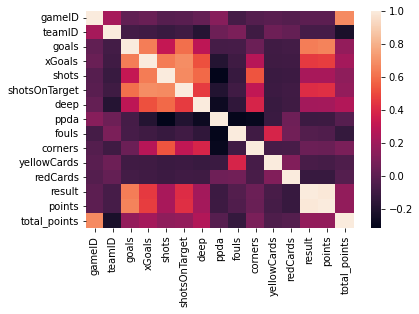

In [121]:
sns.heatmap(teamstats.corr())

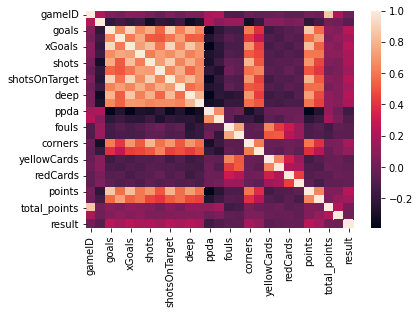

In [122]:
sns.heatmap(teamstats_with_l5.corr())

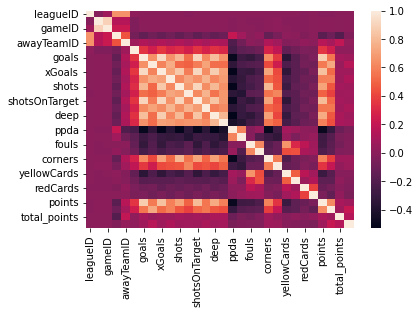

In [123]:
sns.heatmap(matches.corr())  

                    result
result            1.000000
xGoals            0.356093
points            0.353344
goals             0.344554
shotsOnTarget     0.343455
deep              0.340954
shots             0.323569
deep_l5           0.301312
xGoals_l5         0.291867
corners           0.281010
shotsOnTarget_l5  0.279136
shots_l5          0.259246
goals_l5          0.258083
points_l5         0.255809
ppda             -0.243061
corners_l5        0.193188
ppda_l5          -0.159181
yellowCards      -0.138822
fouls            -0.129924
fouls_l5         -0.103276
yellowCards_l5   -0.085345
awayTeamID        0.077930
homeTeamID       -0.070023
redCards_l5      -0.046196
redCards         -0.044039
gameID           -0.038178
season           -0.034643
total_points      0.025275
total_points_l5   0.024557
leagueID          0.015736


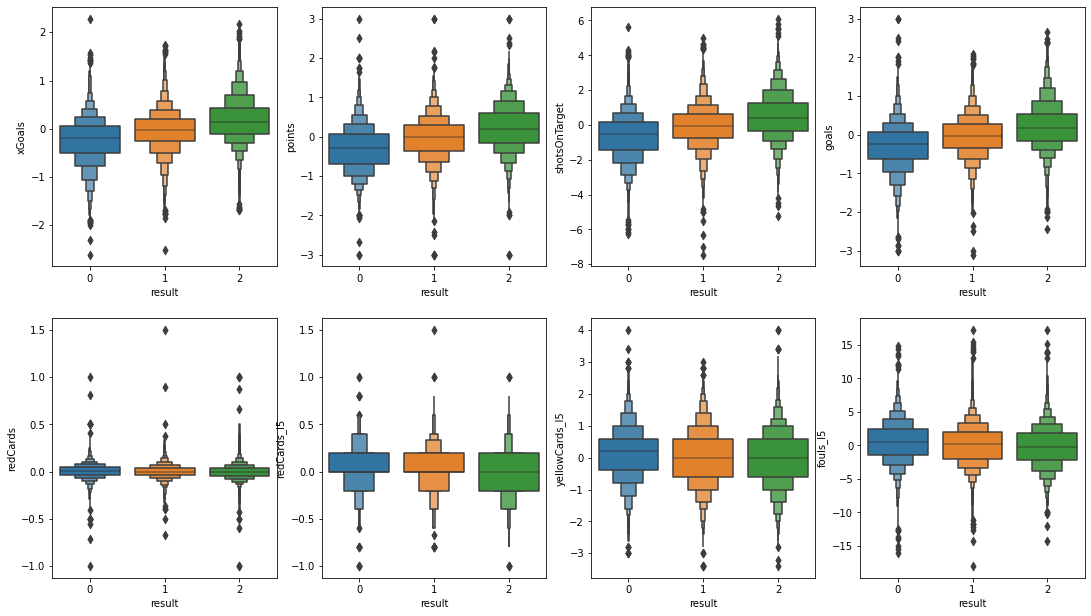

In [124]:
sorted_correlations = pd.DataFrame(data=(matches.corr())["result"].sort_values(ascending=False, key=abs))
print(sorted_correlations)


fig, ax = plt.subplots(2, 4)
fig.set_size_inches(18.5, 10.5)


sns.boxenplot(data=matches, y="xGoals", x="result", ax=ax[0][0])
sns.boxenplot(data=matches, y="points", x="result", ax=ax[0][1])
sns.boxenplot(data=matches, y="shotsOnTarget", x="result", ax=ax[0][2])
sns.boxenplot(data=matches, y="goals", x="result", ax=ax[0][3])


sns.boxenplot(data=matches, y="redCards", x="result", ax=ax[1][0])
sns.boxenplot(data=matches, y="redCards_l5", x="result", ax=ax[1][1])
sns.boxenplot(data=matches, y="yellowCards_l5", x="result", ax=ax[1][2])
sns.boxenplot(data=matches, y="fouls_l5", x="result", ax=ax[1][3])

# MODEL


In [187]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

X = matches.drop(columns=["result", "gameID", "homeTeamID","awayTeamID"])
# X = normalize(X, axis=0)

y = matches["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [188]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs',max_iter=3000)
lr.fit(X_train, y_train)
train_res = (lr.predict(X_train) == y_train).mean()
test_res = (lr.predict(X_test) == y_test).mean()

print("Train: ", train_res)
print("Test: ", test_res)

Train:  0.5259266561514195
Test:  0.5181388012618297


In [189]:
from sklearn.neighbors import KNeighborsClassifier


for k in range(1, 100, 5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_res = (knn.predict(X_train) == y_train).mean()
    test_res = (knn.predict(X_test) == y_test).mean()
    print(f"k={k} - Train: {train_res} Test: {test_res}")

k=1 - Train: 0.9981269716088328 Test: 0.39865930599369087
k=6 - Train: 0.6022279179810726 Test: 0.4522870662460568
k=11 - Train: 0.5666403785488959 Test: 0.47358044164037855
k=16 - Train: 0.5578667192429022 Test: 0.47358044164037855
k=21 - Train: 0.5408123028391167 Test: 0.48501577287066244
k=26 - Train: 0.532038643533123 Test: 0.49290220820189273
k=31 - Train: 0.5334187697160884 Test: 0.5
k=36 - Train: 0.5309542586750788 Test: 0.4964511041009464
k=41 - Train: 0.5318414826498423 Test: 0.5023659305993691
k=46 - Train: 0.5286869085173501 Test: 0.5098580441640379
k=51 - Train: 0.527602523659306 Test: 0.5043375394321766
k=56 - Train: 0.5280954258675079 Test: 0.5106466876971609
k=61 - Train: 0.5281940063091483 Test: 0.5086750788643533
k=66 - Train: 0.5256309148264984 Test: 0.5102523659305994
k=71 - Train: 0.526813880126183 Test: 0.5102523659305994
k=76 - Train: 0.5256309148264984 Test: 0.5043375394321766
k=81 - Train: 0.526320977917981 Test: 0.4996056782334385
k=86 - Train: 0.52296924290220

In [190]:
from xgboost import XGBClassifier

bst = XGBClassifier(n_estimators=1, max_depth=1, learning_rate=1)
bst.fit(X_train, y_train)
train_res = (bst.predict(X_train) == y_train).mean()
test_res = (bst.predict(X_test) == y_test).mean()

print("Train: ", train_res)
print("Test: ", test_res)

Train:  0.5172515772870663
Test:  0.5086750788643533


In [191]:
from sklearn.ensemble import AdaBoostClassifier


adb = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
adb.fit(X_train, y_train)

train_res = (adb.predict(X_train) == y_train).mean()
test_res = (adb.predict(X_test) == y_test).mean()

print("Train: ", train_res)
print("Test: ", test_res)

Train:  0.5318414826498423
Test:  0.5149842271293376


In [192]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_depth=100)
rfc.fit(X_train, y_train)

train_res = (rfc.predict(X_train) == y_train).mean()
test_res = (rfc.predict(X_test) == y_test).mean()

print("Train: ", train_res)
print("Test: ", test_res)

Train:  0.9983241324921136
Test:  0.4996056782334385


#FEATURE SELECTION

In [193]:
def get_features_name(arr):
    names = ["leagueID","season","goals", "goals_l5", "xGoals", "xGoals_l5", "shots", "shots_l5", "shotsOnTarget", "shotsOnTarget_l5",
     "deep", "deep_l5", "ppda", "ppda_l5", "fouls", "fouls_l5", "corners", "corners_l5", "yellowCards", "yellowCards_l5", 
     "redCards", "redCards_l5", "points", "points_l5", "total_points", "total_points_l5"]
    
    return [names[i] for i, x in enumerate(arr) if x]

In [194]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = matches.drop(columns=["gameID","homeTeamID","awayTeamID","result"])
# X[["goals", "goals_l5", "xGoals", "xGoals_l5", "shots", "shots_l5", "shotsOnTarget", "shotsOnTarget_l5",
#      "deep", "deep_l5", "ppda", "ppda_l5", "fouls", "fouls_l5", "corners", "corners_l5", "yellowCards", "yellowCards_l5", 
#      "redCards", "redCards_l5", "points", "points_l5", "total_points", "total_points_l5"]] = normalize(X, axis=0)

y = matches["result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for k in range(1, 24, 2):
    model = LogisticRegression(solver='lbfgs',max_iter=3000)

    rfe = RFE(model, n_features_to_select=k)
    fit = rfe.fit(X_train, y_train)
    print("Num Features: %s" % (fit.n_features_))
    f_list = fit.support_
    print(get_features_name(f_list))
    
    X_train_sel = X_train[get_features_name(f_list)]
    X_test_sel = X_test[get_features_name(f_list)]

    lr = LogisticRegression(solver='lbfgs',max_iter=3000)
    lr.fit(X_train_sel, y_train)
    train_res = (lr.predict(X_train_sel) == y_train).mean()
    test_res = (lr.predict(X_test_sel) == y_test).mean()

    print("Train: ", train_res)
    print("Test: ", test_res)



Num Features: 1
['xGoals']
Train:  0.5165615141955836
Test:  0.5070977917981072
Num Features: 3
['xGoals', 'redCards', 'points']
Train:  0.517941640378549
Test:  0.512223974763407
Num Features: 5
['xGoals', 'xGoals_l5', 'redCards', 'redCards_l5', 'points']
Train:  0.5184345425867508
Test:  0.5173501577287066
Num Features: 7
['goals', 'xGoals', 'xGoals_l5', 'yellowCards', 'redCards', 'redCards_l5', 'points']
Train:  0.51823738170347
Test:  0.5169558359621451
Num Features: 9
['goals', 'xGoals', 'xGoals_l5', 'shotsOnTarget_l5', 'deep', 'yellowCards', 'redCards', 'redCards_l5', 'points']
Train:  0.5216876971608833
Test:  0.5193217665615142
Num Features: 11
['goals', 'xGoals', 'xGoals_l5', 'shotsOnTarget_l5', 'deep', 'ppda', 'yellowCards', 'redCards', 'redCards_l5', 'points', 'points_l5']
Train:  0.5249408517350158
Test:  0.5181388012618297
Num Features: 13
['goals', 'goals_l5', 'xGoals', 'xGoals_l5', 'shotsOnTarget_l5', 'deep', 'ppda', 'fouls', 'yellowCards', 'redCards', 'redCards_l5', 'po